In [3]:
# !pip install  tensorflow  opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 1.4 MB/s eta 0:00:29
    --------------------------------------- 0.9/38.8 MB 11.2 MB/s eta 0:00:04
   --- ------------------------------------ 3.1/38.8 MB 28.6 MB/s eta 0:00:02
   ----- ---------------------------------- 5.7/38.8 MB 36.2 MB/s eta 0:00:01
   ------ --------------------------------- 6.1/38.8 MB 29.8 MB/s eta 0:00:02
   --------- ------------------------------ 9.3/38.8 MB 37.1 MB/s eta 0:00:01
   ------------ --------------------------- 12.5/38.8 MB 50.4 MB/s eta 0:00:01
   ---------------- ----------------------- 15.7/38.8 MB 54.7 MB/s eta 0:00:01
   --

In [15]:
import cv2 
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#use this only when you have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
POS_PATH =os.path.join('data', 'positive')
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data","anchor")

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [6]:
import uuid

In [7]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\220d1489-2f22-11ef-a1c1-983b8f767b99.jpg'

In [12]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname= os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname= os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

    
    cv2.imshow("Image Collection",frame)

    if cv2.waitKey(1) & 0XFF ==ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

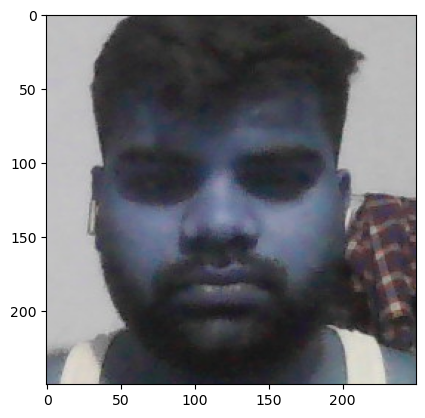

In [17]:
plt.imshow(frame)

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)

In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
print(dir_test.next())

b'data\\anchor\\b3530521-2f22-11ef-bb95-983b8f767b99.jpg'


In [41]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img= tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [42]:
img = preprocess("data\\anchor\\b3530521-2f22-11ef-bb95-983b8f767b99.jpg")

In [43]:
img.numpy().max()

0.967402

In [44]:
plt.show(img)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [46]:
positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
data = positives.concatenate(negatives)

In [47]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [48]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img), label)

In [49]:
samples = data.as_numpy_iterator()


In [50]:
example = samples.next()

In [51]:
example

(b'data\\anchor\\468ad624-2f22-11ef-b66e-983b8f767b99.jpg',
 b'data\\anchor\\3b6070df-2f22-11ef-97ac-983b8f767b99.jpg',
 1.0)

In [52]:
res = preprocess_twin(*example)

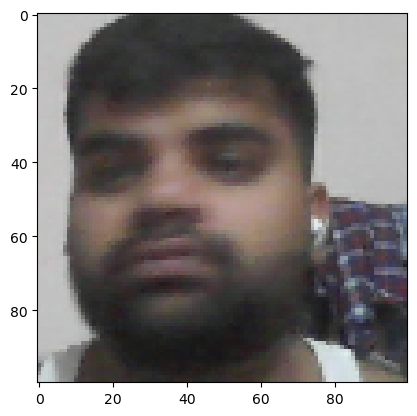

In [57]:
plt.imshow(res[0])

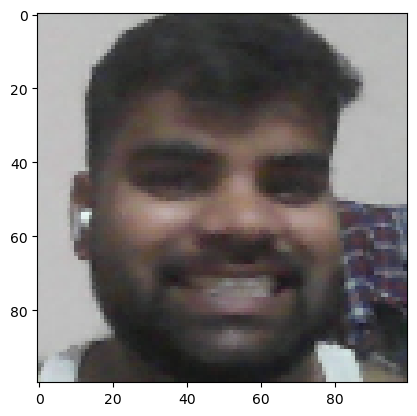

In [55]:
plt.imshow(res[1])

In [56]:
res[2]

1.0

In [58]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [59]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [60]:
test_data = data.skip(round(len(data)*.3))
text_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)